# 1. Import and Install Dependencies

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline
import time # importing time to take sleep between each frame we collect, which is the time to get into action position
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model - make our detection 
mp_drawing = mp.solutions.drawing_utils # Drawing utilities - make our drawings

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(255,255,0), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(255,255,0), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [128]:
cap = cv2.VideoCapture(0)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [119]:
draw_landmarks(frame, results)

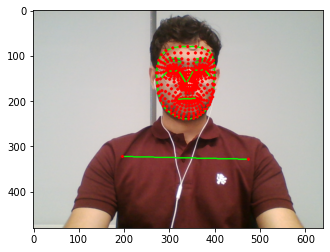

In [120]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [121]:
len(results.left_hand_landmarks.landmark)

AttributeError: 'NoneType' object has no attribute 'landmark'

In [11]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [12]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [13]:
# face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() 
#     if results.left_hand_landmarks 
#     else np.zeros(1404)

In [14]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [15]:
result_test = extract_keypoints(results)

In [16]:
result_test

array([ 0.57291311,  0.32680494, -1.20303023, ...,  0.        ,
        0.        ,  0.        ])

In [17]:
# np.save('0', result_test)

In [18]:
# np.load('0.npy')

# 4. Setup Folders for Collection

In [123]:
# create a main folder for collection
if not os.path.exists(os.path.join('Resources', 'My Sample Data','Test2')):
    os.makedirs(os.path.join('Resources', 'My Sample Data','Test2'))

In [250]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('Resources', 'My Sample Data','Test3')

# Actions that we try to detect
actions = np.array(['NoSign','hello', 'thanks', 'iloveyou'])

# 40 videos worth of data
no_sequences = 30

# Videos are going to be 20 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [125]:
# [30 videos x No. of actions, 30 frames per video, 1662 datapoints per frame]

In [126]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [127]:
# for action in actions: 
#     dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
#     for sequence in range(1,no_sequences+1):
#         try: 
#             os.makedirs(os.path.join(DATA_PATH, action, str(dirmax+sequence)))
#         except:
#             pass

# 5. Collect Keypoint Values for Training and Testing

In [129]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [38]:
cap.release()
cv2.destroyAllWindows()

In [22]:
# actions = np.array(['NoSign','hello', 'thanks', 'iloveyou'])
# label_map = {label:num for num, label in enumerate(actions)}
# # no_sequences = 30
# sequence_length = 30

# DATA_PATH = os.path.join('Resources', 'My Sample Data','Test3')
# sequences3, labels3 = [], []
# for action in actions:
#     for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
#         window = []
#         for frame_num in range(sequence_length):
#             res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
#             window.append(res)
#         sequences3.append(window)
#         labels3.append(label_map[action])
        
# DATA_PATH = os.path.join('Resources', 'My Sample Data','Test4')
# sequences4, labels4 = [], []
# for action in actions:
#     for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
#         window = []
#         for frame_num in range(sequence_length):
#             res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
#             window.append(res)
#         sequences4.append(window)
#         labels4.append(label_map[action])
        
# DATA_PATH = os.path.join('Resources', 'My Sample Data','Test5')
# sequences5, labels5 = [], []
# for action in actions:
#     for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
#         window = []
#         for frame_num in range(sequence_length):
#             res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
#             window.append(res)
#         sequences5.append(window)
#         labels5.append(label_map[action])

In [ ]:
# X3 = np.array(sequences3)
# X4 = np.array(sequences4)
# X5 = np.array(sequences5)

# X_final = np.append(np.append(X3, X4, axis=0),X5, axis=0)

In [ ]:
# y = np.array(labels3+labels4+labels5)
# y_final = to_categorical(y).astype(int)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.05)

# 6. Preprocess Data and Create Labels and Features

In [130]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [131]:
label_map = {label:num for num, label in enumerate(actions)}

In [251]:
label_map

{'NoSign': 0, 'hello': 1, 'thanks': 2, 'iloveyou': 3}

In [252]:
DATA_PATH = os.path.join('Resources', 'My Sample Data','Test3')

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [253]:
np.array(sequences).shape

(160, 30, 1662)

In [254]:
np.array(labels).shape

(160,)

In [255]:
X = np.array(sequences)

In [256]:
X.shape

(160, 30, 1662)

In [257]:
y = to_categorical(labels).astype(int)

In [258]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [259]:
y_test.shape

(8, 4)

# 7. Build and Train LSTM Neural Network

In [277]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

In [278]:
# log_dir = os.path.join('Logs')
# tb_callback = TensorBoard(log_dir=log_dir)

# run on notebook using: %tensorboard --logdir logs/fit

In [279]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [280]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [281]:
path_1 = r'C:\Users\aamir\Desktop\UOWD\4 th year\Autmn 2022 - semester\CSIT321 - Project\Computer Vision\Trial'

In [282]:
# os.path.join(path_1,'Saved Best Models',"ep{epoch:03d}-loss{loss:.3f}.h5")

In [283]:
checkpoint_filepath = os.path.join('Saved Best Models',"test3.h5")
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='categorical_accuracy',
    mode='max',
    save_best_only=True)

In [284]:
#model.fit(X_train, y_train, epochs=100, callbacks=[model_checkpoint_callback])
model.fit(X_train, y_train, epochs=100, callbacks=[model_checkpoint_callback])
#model.fit(X_train, y_train, epochs=1000, batch_size=40, callbacks=[model_checkpoint_callback])

Epoch 1/100
5/5 [==============================] - 3s 106ms/step - loss: 1.4383 - categorical_accuracy: 0.3214
Epoch 2/100
5/5 [==============================] - 0s 97ms/step - loss: 1.6646 - categorical_accuracy: 0.2696
Epoch 3/100
5/5 [==============================] - 0s 100ms/step - loss: 1.3264 - categorical_accuracy: 0.3385
Epoch 4/100
5/5 [==============================] - 1s 107ms/step - loss: 1.0232 - categorical_accuracy: 0.6567
Epoch 5/100
5/5 [==============================] - 1s 105ms/step - loss: 0.8675 - categorical_accuracy: 0.6750
Epoch 6/100
5/5 [==============================] - 1s 101ms/step - loss: 0.8514 - categorical_accuracy: 0.6817
Epoch 7/100
5/5 [==============================] - 1s 100ms/step - loss: 0.8112 - categorical_accuracy: 0.5860
Epoch 8/100
5/5 [==============================] - 1s 103ms/step - loss: 0.6806 - categorical_accuracy: 0.71960s - loss: 0.6801 - categorical_accuracy: 0.71
Epoch 9/100
5/5 [==============================] - 0s 100ms/step - 

5/5 [==============================] - 1s 104ms/step - loss: 1.2811 - categorical_accuracy: 0.6252
Epoch 74/100
5/5 [==============================] - 1s 118ms/step - loss: 1.4604 - categorical_accuracy: 0.3970
Epoch 75/100
5/5 [==============================] - 1s 119ms/step - loss: 5.3898 - categorical_accuracy: 0.3237
Epoch 76/100
5/5 [==============================] - 1s 126ms/step - loss: 13.3593 - categorical_accuracy: 0.2398
Epoch 77/100
5/5 [==============================] - 1s 117ms/step - loss: 10.5475 - categorical_accuracy: 0.1643
Epoch 78/100
5/5 [==============================] - 1s 120ms/step - loss: 4.4510 - categorical_accuracy: 0.2517
Epoch 79/100
5/5 [==============================] - 1s 122ms/step - loss: 27.6469 - categorical_accuracy: 0.3125
Epoch 80/100
5/5 [==============================] - 1s 117ms/step - loss: 1.4624 - categorical_accuracy: 0.1919
Epoch 81/100
5/5 [==============================] - 1s 125ms/step - loss: 1.3874 - categorical_accuracy: 0.3569
Ep

In [220]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 25, 64)            442112    
_________________________________________________________________
lstm_32 (LSTM)               (None, 25, 128)           98816     
_________________________________________________________________
lstm_33 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_32 (Dense)             (None, 4)                 132       
Total params: 596,708
Trainable params: 596,708
Non-trainable params: 0
_______________________________________________

# 8. Make Predictions

In [285]:
res = model.predict(X_test)

In [290]:
test_num = 1

In [291]:
print('Expected: ',actions[np.argmax(res[test_num])])
print('Predicted: ',actions[np.argmax(y_test[test_num])])

Expected:  iloveyou
Predicted:  hello


# 9. Save Weights

In [224]:
#model.save('Model Weights\model_test3_train2.h5') # creates a HDF5 file 'my_model.h5'

In [225]:
#model.load_weights('Saved Best Models\test7_model.h5')

In [238]:
# from tensorflow.keras.models import load_model
# model = load_model('Saved Best Models/test8_model.h5')

In [227]:
#new_model = keras.models.load_model('Model Weights\model_test3_train2.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [292]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report

In [293]:
yhat = model.predict(X_test)

In [294]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [295]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[7, 0],
        [0, 1]],

       [[7, 0],
        [1, 0]],

       [[5, 0],
        [3, 0]],

       [[1, 4],
        [0, 3]]], dtype=int64)

In [296]:
accuracy_score(ytrue, yhat)

0.5

In [297]:
print(classification_report(ytrue, yhat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.43      1.00      0.60         3

    accuracy                           0.50         8
   macro avg       0.36      0.50      0.40         8
weighted avg       0.29      0.50      0.35         8



C:\Users\aamir\anaconda3\envs\AamirAli\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aamir\anaconda3\envs\AamirAli\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aamir\anaconda3\envs\AamirAli\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 11. Test in Real Time

In [245]:
# from scipy import stats

In [246]:
colors = [(245,117,16), (117,245,16), (16,117,245),(16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [247]:
# plt.figure(figsize=(18,18))
# plt.imshow(prob_viz(res, actions, image, colors))

In [248]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [32]:
cap.release()
cv2.destroyAllWindows()

## 25 frames realtime detection

In [249]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        #print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-25:]
        
        if len(sequence) == 25:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
NoSign
NoSign
NoSign
hello
hello
hello
hello
hello
hello
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
thanks
hello
hello
hello
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign
NoSign

In [39]:
# Check the video properties
cap2 = cv2.VideoCapture(0)

print('video frame height = ', cap2.get(cv2.CAP_PROP_FRAME_HEIGHT))
print('video frame width = ',cap2.get(cv2.CAP_PROP_FRAME_WIDTH))

# frame rate being used for frame extraction
print('frame rate = ', cap2.get(cv2.CAP_PROP_FPS))

# frame count in video
print('frame count in video = ', cap2.get(cv2.CAP_PROP_FRAME_COUNT))

video frame height =  480.0
video frame width =  640.0
frame rate =  30.0
frame count in video =  -1.0


# Saving the trained model with weights

In [ ]:
# %%timeit
# %%time

## Pickle

In [40]:
import pickle

In [77]:
# save the model
with open('model_test3_train2.pickle', 'wb') as f: # 'wb' - write binary file
    pickle.dump(model,f)

TypeError: can't pickle weakref objects

Too big can't pickle weakref objects => can't pickle weakref comes because Deep Learning models are too large and pickle only used for storing small models. Use this : HDF5 used for storing large data.

In [ ]:
# # loading the model
# with open('model_test3_train2', 'rb') as f: # 'rb' - read binary file
#     model_test3_train2 = pickle.load(f)

In [69]:
# Doesnt work - 'Sequential' object has no attribute 'to_pickle'
# model.to_pickle('Saved Models\model_pickle2.pickle')
# model_pickl = model.read_pickle('Saved Models\model_pickle2.pickle')

## Parquet

In [71]:
# model.to_parquet('model_pickle2.parquet')

AttributeError: 'Sequential' object has no attribute 'to_parquet'

In [ ]:
# model_pickl = model.read_parquet('model_pickle2.parquet')

## Feather

In [72]:
# model.to_feather('model_pickle2.feather')
# model_pickl = model.read_feather('model_pickle2.feather')

AttributeError: 'Sequential' object has no attribute 'to_feather'

## Joblib

In [75]:
#from sklearn.externals import joblib
import joblib

In [76]:
joblib.dump(model, 'model_test3_train2')

TypeError: can't pickle weakref objects

In [ ]:
#model_test3_train2 = joblib.load('model_test3_train2')